## Imports

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

## Load Data

In [19]:
# Determine the data path
data_path = "../data/final_df.csv"

In [20]:
# Load the dataset
df = pd.read_csv(data_path).drop(columns='Unnamed: 0')
df.head()

cardholder_name       card_number card_type   merchant_name  \
0            Meagan Smith  4408914864277480      visa             KFC   
1  Miss Vanessa Briggs MD  4533948622139044      visa      McDonald's   
2             Casey Lyons  4350240875308199      visa  Domino's Pizza   
3           Cynthia Munoz  4756687869818916      visa      McDonald's   
4               Lynn Pham  4813038430033752      visa     Papa John's   

  merchant_category merchant_state merchant_city  transaction_amount  \
0         Fast Food     New Jersey   Jersey City           38.055684   
1         Fast Food        Montana      Missoula           11.516379   
2         Fast Food           Ohio     Cleveland           12.739792   
3         Fast Food  Massachusetts     Worcester           20.899888   
4         Fast Food      Minnesota    Saint Paul           11.073323   

  merchant_category_code  fraud_flag  
0               MCC 5814           0  
1               MCC 5814           0  
2               MCC 5814           0  
3               MCC 5814           0  
4               MCC 5814           0

## Train-Test Split

In [21]:
# Define X features and y target
X = df.drop('fraud_flag', axis=1)
y = df['fraud_flag']

print(f"X shape ----------- {X.shape}")
print(f"y shape ----------- {y.shape}")

X shape ----------- (100000, 9)
y shape ----------- (100000,)


In [22]:
# defining training and test Xs and ys
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

## Baseline Score

In [23]:
# Get the ratio of classes
y_test.value_counts(normalize=True)

fraud_flag
0    0.836638
1    0.163362
Name: proportion, dtype: float64

**The baseline accuracy is 0.83 which is majority class**

## Catboost Model

In [24]:
# Specify categorical features
cats = ['cardholder_name', 'card_type', 'merchant_name', 'merchant_category',
       'merchant_state', 'merchant_city', 'merchant_category_code']

# Instatiate the model
cb = CatBoostClassifier(iterations=100, cat_features=cats, random_state=42)

# Fit the model
cb.fit(X_train, y_train)

# Get the accuracy score
print(f"Accuracy score is: {cb.score(X_train, y_train)}")

Learning rate set to 0.305826
0:	learn: 0.5619432	total: 53.8ms	remaining: 5.33s
1:	learn: 0.4942667	total: 98.3ms	remaining: 4.82s
2:	learn: 0.4564945	total: 121ms	remaining: 3.92s
3:	learn: 0.4344617	total: 146ms	remaining: 3.51s
4:	learn: 0.4227252	total: 160ms	remaining: 3.04s
5:	learn: 0.4145799	total: 206ms	remaining: 3.23s
6:	learn: 0.4096423	total: 243ms	remaining: 3.22s
7:	learn: 0.4080681	total: 252ms	remaining: 2.9s
8:	learn: 0.4060546	total: 301ms	remaining: 3.04s
9:	learn: 0.4046868	total: 348ms	remaining: 3.13s
10:	learn: 0.4030114	total: 407ms	remaining: 3.29s
11:	learn: 0.4018921	total: 458ms	remaining: 3.35s
12:	learn: 0.4012109	total: 495ms	remaining: 3.31s
13:	learn: 0.4009210	total: 545ms	remaining: 3.35s
14:	learn: 0.4003081	total: 594ms	remaining: 3.36s
15:	learn: 0.3999409	total: 637ms	remaining: 3.34s
16:	learn: 0.3990904	total: 693ms	remaining: 3.38s
17:	learn: 0.3987277	total: 753ms	remaining: 3.43s
18:	learn: 0.3987214	total: 771ms	remaining: 3.29s
19:	learn:

## The Model Evaluation

In [25]:
# Get prediction 
preds = cb.predict(X_test)

# Confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Compute confusion matrix 
conf_matrix = confusion_matrix(y_test, preds)

# Create display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(values_format='d', cmap=plt.cm.Blues)

# Define the title
plt.title(f"The Confusion Matrix of Catboost Model");

print(f" Evaluation Metrics ".center(34, "="))
print(f"Accuracy -------------- {accuracy_score(y_test, preds)}")
print(f"Precision ------------- {precision_score(y_test, preds)}")
print(f"Sensitivity ----------- {recall_score(y_test, preds)}")
print(f"Specifity ------------- {tn/(tn+fp)}")
print(f"F1 score -------------- {f1_score(y_test, preds)}")

======= Evaluation Metrics =======
Accuracy -------------- 0.856875
Precision ------------- 0.6527070364082249
Sensitivity ----------- 0.2647486418241641
Specifity ------------- 0.9724940610479449
F1 score -------------- 0.376701143168209


## The Model Feature Importance

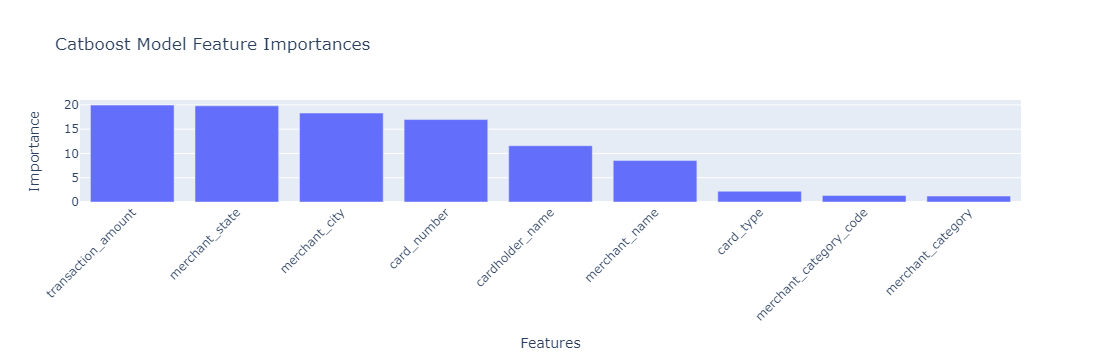

In [26]:
# Get the feature importance values
feature_importance = cb.feature_importances_

# Get feature names
feature_names = cb.feature_names_

# sort features in descending orders
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Create a bar plot
fig = go.Figure(data=[go.Bar(x=sorted_feature_names, y=sorted_feature_importance)])

fig.update_layout(title="Catboost Model Feature Importances", xaxis_title="Features", yaxis_title="Importance", xaxis_tickangle=-45)
fig.show()

## LightGBM Model

In [27]:
#X_encoded = pd.get_dummies(X, drop_first=True)

In [28]:
X['merchant_city'].value_counts()

merchant_city
Portland     2029
Fargo        1964
Columbia     1961
Chicago      1095
New York     1077
             ... 
Denver        957
San Diego     949
Casper        947
Lincoln       929
Dover         922
Name: count, Length: 97, dtype: int64

In [34]:
cats = ['cardholder_name', 'card_type', 'merchant_name', 'merchant_category',
       'merchant_state', 'merchant_city', 'merchant_category_code']

for col in cats:
    print(df[col].value_counts())

cardholder_name
Michael Johnson        39
Jennifer Smith         35
Michael Davis          34
Christopher Johnson    34
Michael Brown          33
                       ..
Alexandra Nelson        1
Robert Rodgers          1
Melanie Roth            1
Eugene Torres           1
Shannon Kerr            1
Name: count, Length: 70980, dtype: int64
card_type
visa          25000
mastercard    25000
amex          25000
discover      25000
Name: count, dtype: int64
merchant_name
Morton's The Steakhouse                 1749
McDonald's                              1749
Chipotle                                1748
Subway                                  1744
Canlis                                  1739
Gary Danko                              1738
Del Frisco's Double Eagle Steakhouse    1734
Papa John's                             1731
Carrabba's Italian Grill                1715
Commander's Palace                      1712
Five Guys                               1708
Cheesecake Factory              

In [36]:
for col in cats:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col].astype(str))
    print(X[col].value_counts())

cardholder_name
48271    39
30729    35
48094    34
13875    34
48008    33
         ..
1339      1
57591     1
47305     1
23695     1
61322     1
Name: count, Length: 70980, dtype: int64
card_type
3    25000
2    25000
0    25000
1    25000
Name: count, dtype: int64
merchant_name
35    1749
33    1749
14    1748
53    1744
8     1739
24    1738
18    1734
42    1731
9     1715
15    1712
22    1708
10    1699
1     1697
7     1695
21    1695
58    1694
50    1689
40    1684
27    1682
4     1680
59    1677
55    1677
43    1675
0     1671
25    1670
36    1669
54    1668
39    1667
34    1662
19    1661
5     1660
20    1660
56    1657
37    1655
3     1655
45    1652
6     1649
57    1649
30    1649
44    1647
17    1647
38    1644
12    1643
52    1642
23    1638
47    1637
32    1635
2     1634
28    1634
13    1634
26    1633
29    1624
51    1622
46    1619
41    1617
11    1613
16    1610
31    1606
48    1581
49    1575
Name: count, dtype: int64
merchant_category
1    33550
2 

In [37]:
# Apply TruncatedSVD for dimensionality redustion
# svd = TruncatedSVD(n_components=100)
# X_svd = svd.fit_transform(X_encoded)

# Apply PCA
# pca = PCA(n_components=0.95)  # Retain 95% of variance
# X_pca = pca.fit_transform(X_encoded)

# Split data into train and test sets
X_train, X_test, y_train, y_test, =train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize data
# sc = StandardScaler()
# X_train_sc = sc.fit_transform(X_train)
# X_test_sc = sc.fit_transform(X_test)

# Set lightgbm train and test data
# categorical_feature = [0, 2, 3, 4, 5, 6, 8]

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_error',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

num_round = 100

bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

preds = bst.predict(X_test, num_iteration=bst.best_iteration)

preds_binary = [1 if x>= 0.5 else 0 for x in preds]


In [38]:
# Confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_binary).ravel()

# Compute confusion matrix 
conf_matrix = confusion_matrix(y_test, preds_binary)

# Create display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(values_format='d', cmap=plt.cm.Blues)

# Define the title
plt.title(f"The Confusion Matrix of LightGBM");

print(f" Evaluation Metrics ".center(34, "="))
print(f"Accuracy -------------- {accuracy_score(y_test, preds_binary)}")
print(f"Precision ------------- {precision_score(y_test, preds_binary)}")
print(f"Sensitivity ----------- {recall_score(y_test, preds_binary)}")
print(f"Specifity ------------- {tn/(tn+fp)}")
print(f"F1 score -------------- {f1_score(y_test, preds_binary)}")

======= Evaluation Metrics =======
Accuracy -------------- 0.85465
Precision ------------- 0.6700787401574804
Sensitivity ----------- 0.2548667265648398
Specifity ------------- 0.9748514494928275
F1 score -------------- 0.36927750054241704
